# Déconstruction et reconstruction du signal

Dans ce notebook, nous allons manipuler des signaux jouets, que nous essaierons de décomposer puis reconstruire afin d'observer le résultat.

Nous commençons par importer le solveur.

In [1]:
import ot
import scipy.optimize, scipy.signal
import numpy as np
import matplotlib.pyplot as plt

def frequential_cost_matrix(F):
    """
    Generates a frequential cost matrix, i.e. the frequency moving cost.
    ---
    Inputs:
        - F : 1-D float array. The range of frequencies to be considered.
    ---
    Outputs
        - C : 2-D float array. The wanted cost matrix.
    """
    M = F.shape[0]
    C = np.zeros((M,M))
    for i in range(M):
        for j in range(M):
            C[i,j] = (F[i]-F[j])**2
    return C

def simplex_OT_canonical_matrices(v, W, C):
    """
    Generates the canonical matrices for the simplex algorithm.
    ---
    Inputs:
        - v : 1-D float array. The target trame to be matched.
        - W : 2-D float array. The signal dictionnary.
        - C : 2-D float array. The frequential cost matrix.
    ---
    Outputs:
        - c : 1-D float array. The objective function vector for the simplex algorithm 
                    (i.e. the flattened cost matrix).
        - A : 2-D float array. The left-side (variables sided) equality matrix for the simplex algorithm.
        - b : 1-D float array. The right-side (value constraints) equality vector for the simplex algorithm.
    """
    M = v.shape[0]
    K = W.shape[1]
    # Coefficients for minimization
    c = np.zeros((M**2+ K,))
    #Constraints matrix and vertice
    A = np.zeros((2*M,M**2+ K))
    b = np.zeros((2*M,))
    
    # c is unfolding C and letting zeros after
    c[:M**2] =  [C[i//M, i%M] for i in range(M**2)]
    
    # Writing first constraints set
    for i in range(M):
        for j in range(M):
            A[i, i*M+j] = 1
        b[i] = v[i] 
    
    # Writing second constraints set
    for j in range(M):
        for i in range(M):
            A[M + j, i*M+j] = 1
        for k in range(K):
            A[M + j, M**2 +k] = -W[j,k]
    
    # Returning matrices
    return c, A, b

def simplex_algorithm(c, A, b):
    """
    Returns the optimal solution found by the simplex algorithm.
    ---
    Inputs:
        - c : 1-D float array. The objective function vector for the simplex algorithm 
                    (i.e. the flattened cost matrix).
        - A : 2-D float array. The left-side (variables sided) equality matrix for the simplex algorithm.
        - b : 1-D float array. The right-side (value constraints) equality vector for the simplex algorithm.
    ---
    Outputs:
        - x : 1-D float array. The simplex's optimal solution, 
                    i.e. the vector that minimizes <c.x>, 
                    so that Ax = b.            
    """
    #result = scipy.optimize.linprog(c, method="simplex", options={'A':A, 'b':b})
    result = scipy.optimize.linprog(c, A_eq=A, b_eq=b,bounds=(0, None))
    if not result.success:
        print("Failure: ", result.message)
    print("Simplex iterations:", result.nit)
    return result.x

def compute_NMF(v,W,C):
    """
    Computes a Non-negative Matrix Factorization of v based on W, optimizing with respects to C.
    ---
    Inputs:
        - v : 1-D float array. The target trame to be matched.
        - W : 2-D float array. The signal dictionnary.
        - C : 2-D float array. The frequential cost matrix.
    ---
    Outputs:
        - h : 1-D float array. An optimal vector so that v ~ Wh, with respects to C.
    """
    c, A, b = simplex_OT_canonical_matrices(v, W, C)
    th = simplex_algorithm(c, A, b)
    K = W.shape[1]
    h = th[-K:]
    return h

def slice_spectrogram(f, t, S, fmin=0, fmax=50000):
    """
    Slices the frequences of a spectrogram.
    -- 
    Inputs:
        - f : 1-D float array. The spectrogram's frequency values.
        - t : 1-D float array. The spectrogram's time values.
        - S : 2-D float array. The spectrogram.
    ---
    Parameters:
        - fmin : float. The spectrogram slice's minimal frequency.
        - fmax : float. The spectrogram slice's maximal frequency.
    ---
    Outputs:
        - f : 1-D float array. The sliced spectrogram's frequency values.
        - t : 1-D float array. The sliced spectrogram's time values.
        - S : 2-D float array. The slicespectrogram.
    """
    freq_slice = np.where((f >= fmin) & (f <= fmax) )

    f = f[freq_slice]
    S = S[freq_slice,:][0]

    return f, t, S

def get_spectrogram(s, fs, fmin=0, fmax=50000, nperseg = 1024):
    """
    Returns the spectrogram of a signal s.
    ---
    Inputs:
        - s : 1-D float array. The considered signal.
        - fs : float. The sampling frequency of the signal.
    ---
    Parameters:
        - fmin : float. The spectrogram slice's minimal frequency.
        - fmax : float. The spectrogram slice's maximal frequency.
        - nperseg : int. Number of samples per spectrogram segment. 
                         Note that it results in lesser time samples in the spectrogram.
    ---
    Outputs:
        - f : 1-D float array. The spectrogram's frequency values.
        - t : 1-D float array. The spectrogram's time values.
        - S : 2-D float array. The spectrogram.
    """
    f, t, S = scipy.signal.spectrogram(s, fs=fs, nperseg= nperseg)
    f, t, S = slice_spectrogram(f, t, S, fmin, fmax)
    return f, t, S

def normalize_trame(v):
    """
    Normalizes a spectrogram trame v.
    ---
    Inputs:
        - v : 1-D float array. The spectrogram trame
    ---
    Outputs:
        - normalized_v: 1-D float array. The normalized spectrogram trame
    """
    normalized_v = v/np.sum(v)
    return normalized_v

Nous définissons de quoi manipuler des signaux jouets.

In [2]:
def sinusoidals(frequencies, time):
    return np.array([np.sum([np.sin(2*np.pi*f*t) for f in frequencies]) for t in T])

## Contexte

Nous définissons ici le contexte de l'étude.

In [3]:
# Sampling frequency
fs = 1e3

# Samples number
N = int(1e6)
# Time
T = np.arange(N) / fs

# Spectrogram parameters
FMIN = 0
FMAX = 15
NPERSEG = 4096

# Results from spectrograms
z = np.zeros((N,))
FS, TS, _ = get_spectrogram(z, fs, fmin = FMIN, fmax = FMAX, nperseg = NPERSEG)

print("Number of relevent frequencies:",FS.shape[0])
print("Frenquency precision:", FS[1]-FS[0], "Hz")
print("Number of trames: ", TS.shape[0])
print("Total duration:", TS[-1],"s")
print("Trame duration:", TS[-1]/TS.shape[0],"s")

elementary_signals = []
elementary_spectrograms = []

Number of relevent frequencies: 62
Frenquency precision: 0.244140625 Hz
Number of trames:  278
Total duration: 994.816 s
Trame duration: 3.578474820143885 s


## Signaux élémentaires

### Artefact de pouls

Nous considèrerons ici l'artefact de pouls comme une sinusoide de fréquence 1 Hz.

Signal d'artefact de pouls


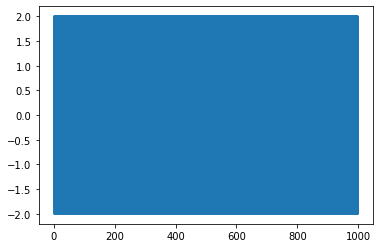

Signal d'artefact de pouls (zoomé)


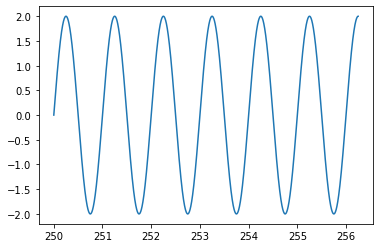

Spectrogramme de l'artefact de pouls


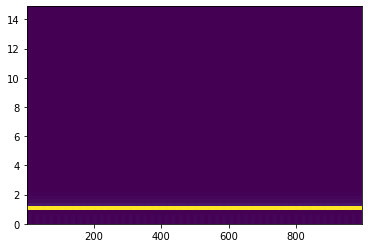

In [4]:
pulse_artifact_frequencies = [1]

toy_pulse_artifact = 2*sinusoidals(pulse_artifact_frequencies, T)

print("Signal d'artefact de pouls")
plt.plot(T, toy_pulse_artifact)
plt.show()

start = len(T)//4
size = len(T)//160
print("Signal d'artefact de pouls (zoomé)")
plt.plot(T[start: start+size], toy_pulse_artifact[start: start+size])
plt.show()

_, _, toy_pulse_spectrogram = get_spectrogram(toy_pulse_artifact, fs, fmin = FMIN, fmax = FMAX, nperseg = NPERSEG)
print("Spectrogramme de l'artefact de pouls")
plt.pcolormesh(TS, FS, toy_pulse_spectrogram)
plt.show()

elementary_signals.append(toy_pulse_artifact)
elementary_spectrograms.append(toy_pulse_spectrogram)

### Artefact de gradient

Nous considèrerons ici cet artefact comme la somme de trois sinusoides, de fréquences .

Signal d'artefact de gradient


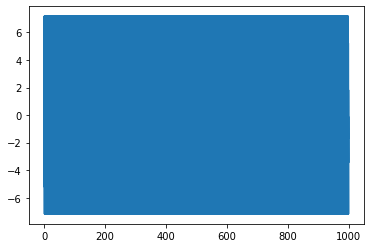

Signal d'artefact de gradient (zoomé)


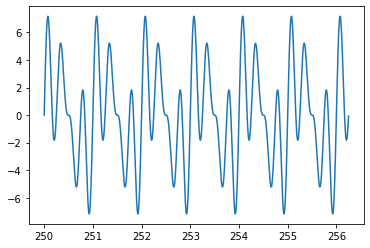

Spectrogramme de l'artefact de gradient


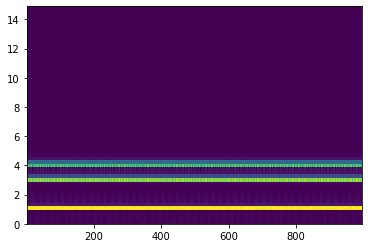

In [5]:
gradient_artifact_frequencies = [1,3,4]

toy_gradient_artifact = 3*sinusoidals(gradient_artifact_frequencies, T)

print("Signal d'artefact de gradient")
plt.plot(T, toy_gradient_artifact)
plt.show()

start = len(T)//4
size = len(T)//160
print("Signal d'artefact de gradient (zoomé)")
plt.plot(T[start: start+size], toy_gradient_artifact[start: start+size])
plt.show()

_,_, toy_gradient_spectrogram = get_spectrogram(toy_gradient_artifact, fs, fmin = FMIN, fmax = FMAX, nperseg = NPERSEG)
print("Spectrogramme de l'artefact de gradient")
plt.pcolormesh(TS, FS, toy_gradient_spectrogram)
plt.show()

elementary_signals.append(toy_gradient_artifact)
elementary_spectrograms.append(toy_gradient_spectrogram)

### Signal d'intérêt

Nous considèrerons ici un signal d'intérêt constitué de deux sinusoïdes de fréquences 6 Hz et 8 Hz, situées dans la bande alpha.

Signal d'intérêt


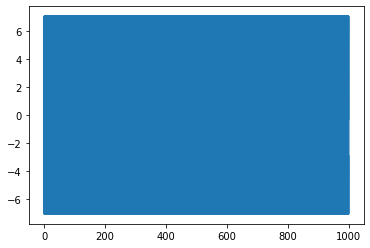

Signal d'intérêt (zoomé)


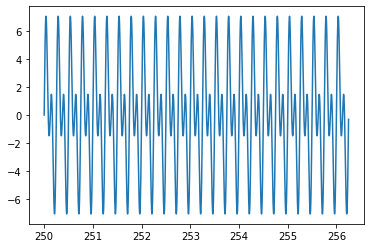

Spectrogramme du signal d'intérêt


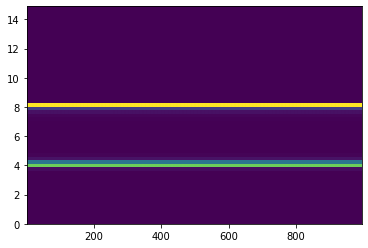

In [6]:
interest_frequencies = [4,8]

toy_interest_signal = 4*sinusoidals(interest_frequencies, T)

print("Signal d'intérêt")
plt.plot(T, toy_interest_signal)
plt.show()

start = len(T)//4
size = len(T)//160
print("Signal d'intérêt (zoomé)")
plt.plot(T[start: start+size], toy_interest_signal[start: start+size])
plt.show()

_,_, toy_interest_spectrogram = get_spectrogram(toy_interest_signal, fs, fmin = FMIN, fmax = FMAX, nperseg = NPERSEG)
print("Spectrogramme du signal d'intérêt")
plt.pcolormesh(TS, FS, toy_interest_spectrogram)
plt.show()

elementary_signals.append(toy_interest_signal)
elementary_spectrograms.append(toy_interest_spectrogram)

### Bruit blanc

Afin de rendre nos signaux plus réalistes, nous allons les bruiter avec du bruit blanc.

Bruit blanc


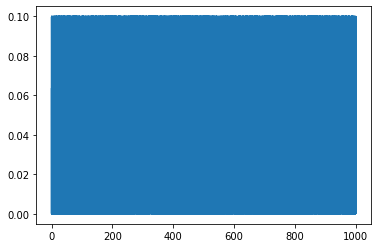

Bruit blanc (zoomé)


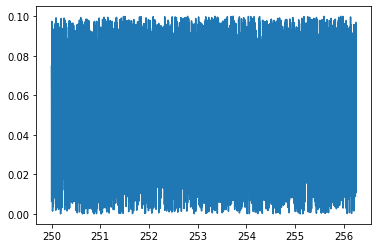

Spectrogramme du bruit blanc


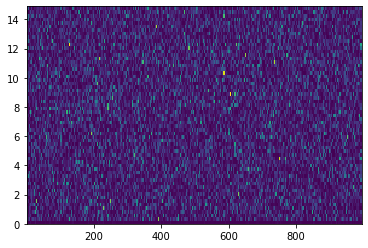

In [7]:
import random
# White noise, i.e a random signal
white_noise = np.array([random.random()/10 for t in T])

print("Bruit blanc")
plt.plot(T, white_noise)
plt.show()

start = len(T)//4
size = len(T)//160
print("Bruit blanc (zoomé)")
plt.plot(T[start: start+size], white_noise[start: start+size])
plt.show()

_, _, white_noise_spectrogram = get_spectrogram(white_noise, fs, fmin = FMIN, fmax = FMAX, nperseg = NPERSEG)
print("Spectrogramme du bruit blanc")
plt.pcolormesh(TS, FS, white_noise_spectrogram)
plt.show()

elementary_signals.append(white_noise)
elementary_spectrograms.append(white_noise_spectrogram)

### Construction du signal étudié

Nous combinons enfin tous ces signaux dans un seul signal que nous étudierons par la suite.

Signal d'étude


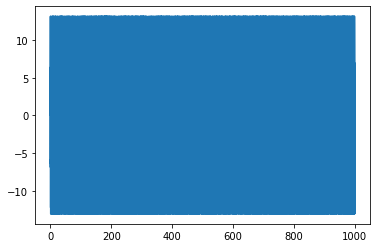

Signal d'intérêt (zoomé)


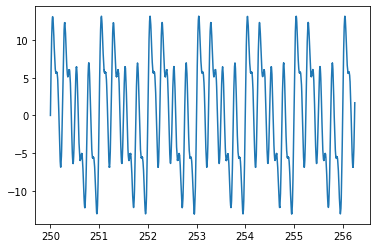

Spectrogramme du signal d'étude


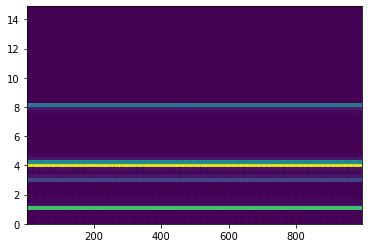

In [8]:
toy_study_signal = np.sum(elementary_signals, axis = 0)

print("Signal d'étude")
plt.plot(T, toy_study_signal)
plt.show()

start = len(T)//4
size = len(T)//160
print("Signal d'intérêt (zoomé)")
plt.plot(T[start: start+size], toy_study_signal[start: start+size])
plt.show()

_,_, toy_study_spectrogram = get_spectrogram(toy_study_signal, fs, fmin = FMIN, fmax = FMAX, nperseg = NPERSEG)
print("Spectrogramme du signal d'étude")
plt.pcolormesh(TS, FS, toy_study_spectrogram)
plt.show()

## Implémentation du solveur

### Définition du dictionnaire

La génération du dictionnaire consiste à isoler une trame normalisée (au milieu du spectrogramme pour limiter les effets de bords) pour chaque signal.

On suppose (pour le moment) la constance de celles-ci dans le temps

Representation of W


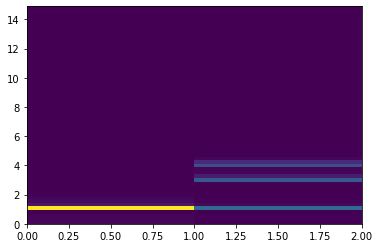

In [9]:
W = np.array([normalize_trame(spec[:,len(TS)//2]) for spec in elementary_spectrograms[:-1]]).transpose()

print("Representation of W")
plt.pcolormesh(np.arange(W.shape[1]+1),FS, W)
plt.show()

## Définition de la matrice de coût

Nous définissons une matrice de coût. Nous choisissons ici le carré des fréquences, ce qui ne devrait pas poser de problème au vu de leur petite valeur.

In [10]:
C = frequential_cost_matrix(FS)

## Décomposition du spectrogramme

Nous allons désormais tâcher une décomposition du spectrogramme sur une de ses trames normalisées.

In [11]:
study_trame = normalize_trame(toy_study_spectrogram[:,len(TS)//2])

decomposition = compute_NMF(study_trame, W, C)

print("Decomposition trouvée :")
print(decomposition)

Simplex iterations: 30
Decomposition trouvée :
[0.03979417 0.63449637 0.32570946]


## Reconstruction du spectrogramme et des signaux

### Reconstruction du signal

Signal recomposé :


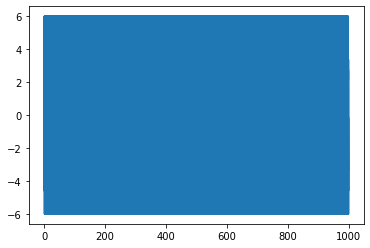

Signal d'origine :


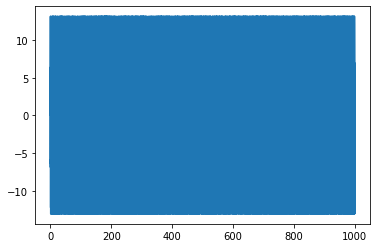

Signal recomposé (zoomé) :


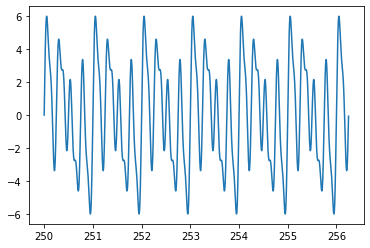

Signal d'origine (zoomé) :


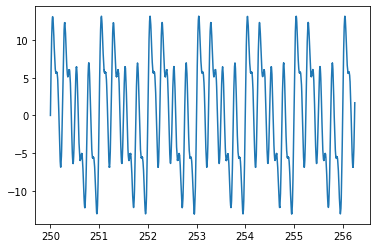

In [12]:
normalized_recomposed_signal = np.dot(decomposition, elementary_signals[:-1])

print("Signal recomposé :")
plt.plot(T, normalized_recomposed_signal)
plt.show()

print("Signal d'origine :")
plt.plot(T, toy_study_signal)
plt.show()


start = len(T)//4
size = len(T)//160
print("Signal recomposé (zoomé) :")
plt.plot(T[start: start+size], normalized_recomposed_signal[start: start+size])
plt.show()

print("Signal d'origine (zoomé) :")
plt.plot(T[start: start+size], toy_study_signal[start: start+size])
plt.show()

### Reconstruction du spectrogramme

Spectrogramme recomposé


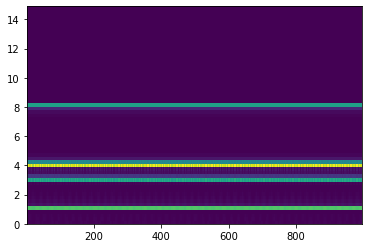

Spectrogramme d'origine


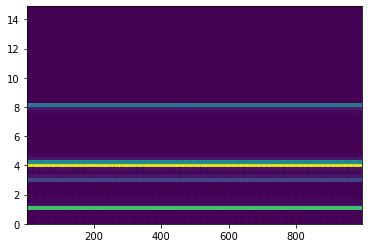

Spectrogramme d'intérêt recomposé


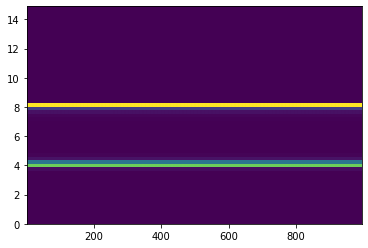

Spectrogramme d'intérêt d'origine


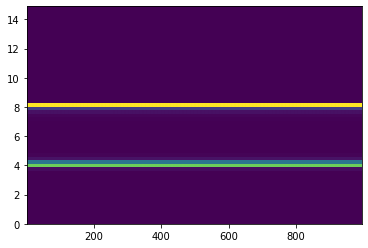

In [14]:
recomposed_spectrogram = ( decomposition[0]*elementary_spectrograms[0]
                         + decomposition[1]*elementary_spectrograms[1]
                         + decomposition[2]*elementary_spectrograms[2] )

interest_recomposed_spectrogram = decomposition[2]*elementary_spectrograms[2]

print("Spectrogramme recomposé")
plt.pcolormesh(TS, FS, recomposed_spectrogram)
plt.show()

print("Spectrogramme d'origine")
plt.pcolormesh(TS, FS, toy_study_spectrogram)
plt.show()

print("Spectrogramme d'intérêt recomposé")
plt.pcolormesh(TS, FS, interest_recomposed_spectrogram)
plt.show()

print("Spectrogramme d'intérêt d'origine")
plt.pcolormesh(TS, FS, toy_interest_spectrogram)
plt.show()